In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dtreeviz.trees import dtreeviz
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_init = pd.read_csv('data.csv', sep=';')
df_init.head()

,Id,Result,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_109,Feature_110,Feature_111,Feature_112,Feature_113,Feature_114,Feature_115,Feature_116,Feature_117,Feature_118
0,1,2,2,56,12,1,7.0,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,1,1,0
1,2,2,2,69,19,1,6.0,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,1
2,3,2,1,66,8,1,4.0,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0
3,4,2,2,62,16,1,NaN,3.0,0,1.0,...,1.0,0.0,1,0,1,1,0,0,1,1
4,5,2,2,67,30,1,NaN,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0


In [3]:
def train(df, trash_features = [], drop_susp_features = True):

    df_ = df.copy()

    target_feature = 'Result'
    num_features = ['Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46',
                    'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 'Feature_53', 'Feature_55', 'Feature_57', 
                    'Feature_58', 'Feature_59', 'Feature_64', 'Feature_70', 'Feature_71', 'Feature_72', 'Feature_73']
    for col in df_.columns:
        if col in num_features:
            df_[col].fillna(df_[col].median(), inplace=True)
            df_[col].astype('float64')
        else:
            df_[col].fillna(-1, inplace=True)
            df_[col].astype('int64')

    golden_features = ['Feature_3', 'Feature_4', 'Feature_35']
    susp_features = ['Feature_29', 'Feature_30', 'Feature_32', 'Feature_101'] if drop_susp_features else []
    all_features = df_.columns.drop([target_feature] + golden_features + susp_features + trash_features + ['Id']).tolist()

    df_ = df_[[target_feature] + all_features]

    # Result=0 - alive, Result=1 died
    df_.loc[df_[target_feature] == 1, target_feature] = 1
    df_.loc[df_[target_feature] == 2, target_feature] = 0

    X = df_[all_features]
    y = df_[target_feature]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        shuffle=True,
        test_size=0.1,
        random_state=0,
        stratify=y,
    )

    over_sampler = RandomOverSampler(
        random_state=0
    )
    X_bal_over, y_bal_over = over_sampler.fit_resample(
        X_train,
        y_train,
    )

    params_frozen = {
        'random_state': 0
    }

    params_grid = {
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [1, 2.5, 5],
        'max_depth': [3, 6, 10],
        'class_weight': ['None', 'balanced'],
    }

    gs = RandomizedSearchCV(
        DecisionTreeClassifier(**params_frozen),
        params_grid,
        scoring='accuracy',
        n_iter=50,
        cv=5,
        refit=False,
        verbose=0,
    )
    gs.fit(X_bal_over, y_bal_over)

    clf = DecisionTreeClassifier(**params_frozen, **gs.best_params_)
    clf.fit(X_bal_over, y_bal_over)

    feature_importances = pd.DataFrame(
        zip(X_bal_over.columns, clf.feature_importances_),
        columns=['feature_name', 'importance']
    )

    return clf, df_, X_bal_over, X_test, y_bal_over, y_test, all_features, target_feature, feature_importances

In [4]:
_, _, _, _, _, _, _, _, feature_importances = train(df_init)

trash_features=feature_importances[feature_importances['importance'] == 0 ]['feature_name'].tolist()

clf, df, X_train, X_test, y_train, y_test, all_features, target_feature, feature_importances = train(
    df_init,
    trash_features=trash_features,
    drop_susp_features=False,
)

## Metrics and classification report

In [5]:
y_test_pred = clf.predict(X_test)

print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
print(f'F1 Score: {round(f1_score(y_test, y_test_pred), 2)}')
print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')

Accuracy: 0.93
F1 Score: 0.91

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.83      1.00      0.91         5

    accuracy                           0.93        15
   macro avg       0.92      0.95      0.93        15
weighted avg       0.94      0.93      0.93        15



## Confusion matrix

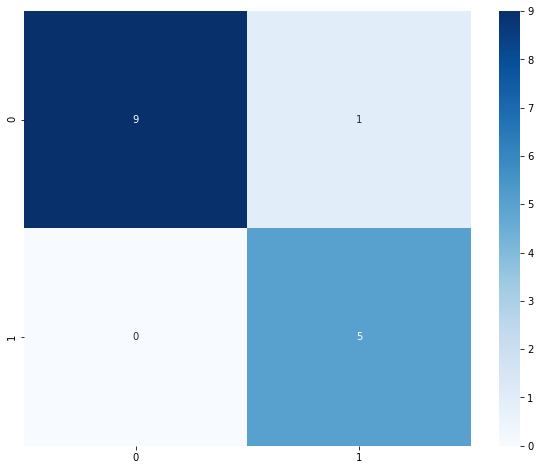

In [6]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues')

## Feature importances

In [7]:
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(50)

,feature_name,importance
15,Feature_101,0.807999
12,Feature_70,0.093531
9,Feature_47,0.038462
0,Feature_2,0.022428
10,Feature_48,0.021846
6,Feature_41,0.015734
14,Feature_100,0.000000
13,Feature_83,0.000000
11,Feature_59,0.000000
8,Feature_46,0.000000


## Correlation matrix with target variable

Text(0.5, 1.0, 'Correlation with target variable')

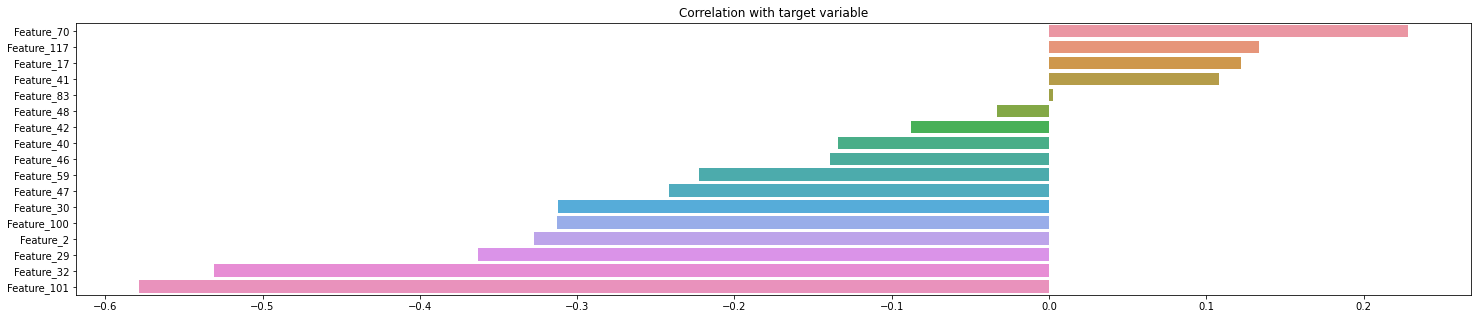

In [8]:
corr_with_target = df[all_features + [target_feature]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(25, 5))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')

## Correlation between features

Text(0.5, 1.0, 'Correlation matrix')

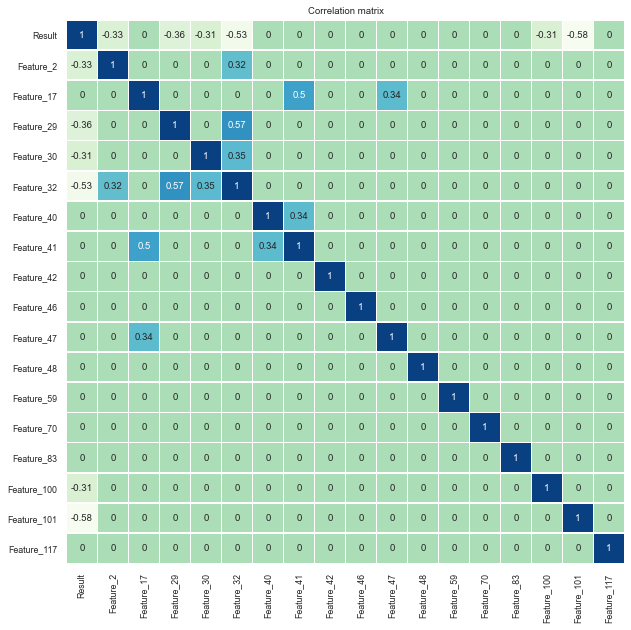

In [9]:
plt.figure(figsize = (10,10))
sns.set(font_scale=0.8)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu', cbar=False)
plt.title('Correlation matrix')

## Tree view

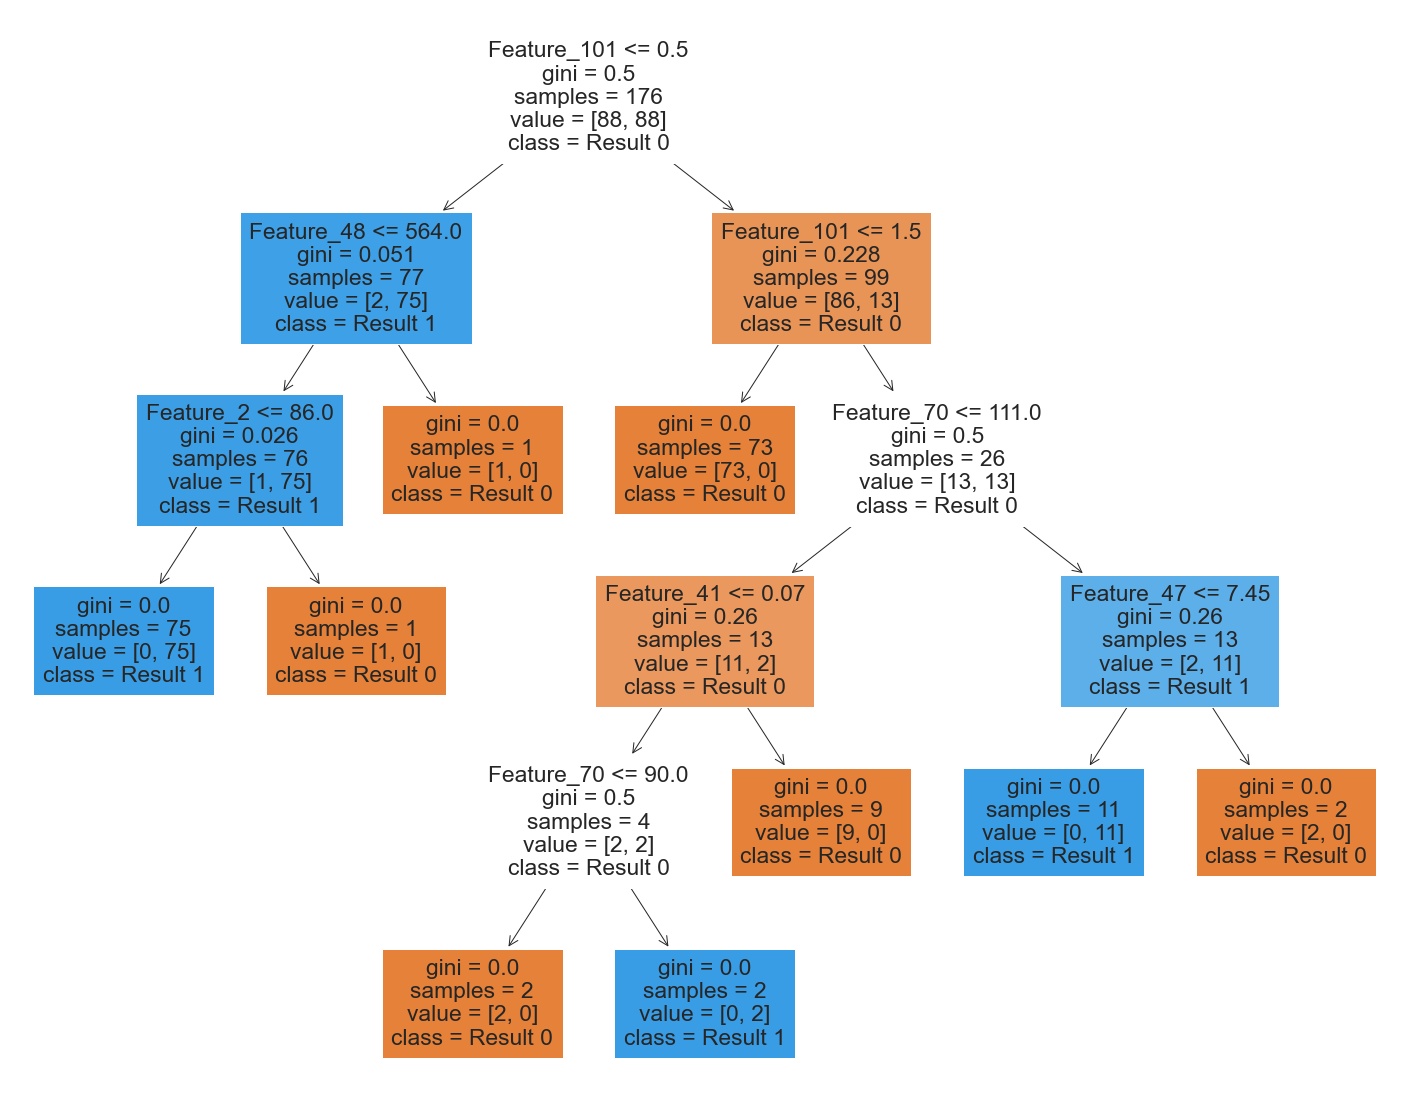

In [10]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(
    clf,
    feature_names=all_features,
    class_names=['Result 0', 'Result 1'],
    filled=True
)

## Alternative tree view with distribution

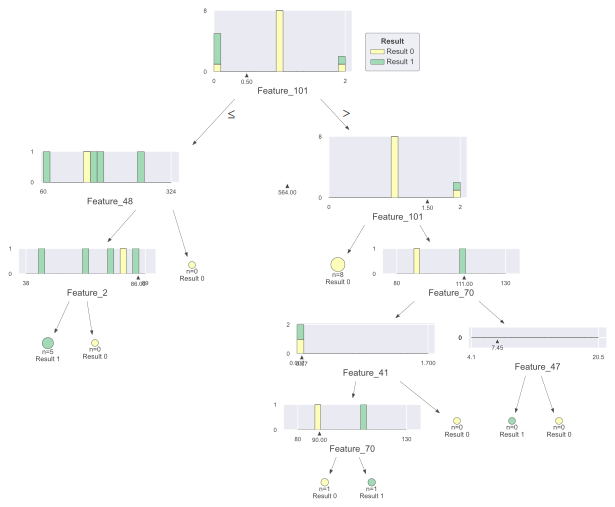

In [11]:
viz = dtreeviz(
    clf,
    X_test,
    y_test,
    target_name=target_feature,
    feature_names=all_features,
    class_names=['Result 0', 'Result 1']
)
viz